# Simpsons Character Classifier 

<img src="n02112018_150.jpg" style="width:1200px;height:400px;">

## Goals:
### 1. Reuse Inception V3 model to train on dog breed data
### 2. Freeze most of the layers
### 3. Cut top layer and add new Fully COnnected layer
### 4. Retrain just top layers 
### 5. EValuate Model


### Import python packages

In [1]:


from keras import regularizers
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation,Dense
from keras.models import Sequential,load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from numpy.random import rand
from keras.callbacks import ModelCheckpoint

# Scikit Imports
from sklearn.model_selection import train_test_split
# Matplot Imports
import matplotlib.pyplot as plt
from keras.models import model_from_json

import seaborn as sns 


Using TensorFlow backend.


In [2]:
# Intialize matplotlib parameters

pd.options.display.max_colwidth = 600


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

## Get Dataset

The Stanford Dog breed dataset is available at [Kaggle/Dogbreed](https://www.kaggle.com/c/dog-breed-identification/data).

The download consists of train, test and label files

In [3]:
train_folder = '/Volumes/My Passport for Mac/data/dog-breeds/train/'
test_folder = '/Volumes/My Passport for Mac/data/dog-breeds/test/'

In [4]:
data_labels = pd.read_csv('/Volumes/My Passport for Mac/data/dog-breeds/labels.csv')
data_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
data_labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,897ffbc20e2ee537a3bf595d4cb0895f,scottish_deerhound
freq,1,126


## Check Number of Classes in the Dataset

The dataset contain 120 different dog breeds

In [6]:
target_labels = data_labels['breed']
len(set(target_labels))
print(target_labels[0:5])

0         boston_bull
1               dingo
2            pekinese
3            bluetick
4    golden_retriever
Name: breed, dtype: object


## Prepare Labels
Deep Learning models work with one hot encoded outputs or target variables. We utilize pandas to prepare one hot encoding for the labels.

In [7]:
labels_ohe_names = pd.get_dummies(target_labels, sparse=True)

print(labels_ohe_names.shape)
labels_ohe = np.asarray(labels_ohe_names)
labels_ohe_names.to_csv("labels.csv")
print(type(labels_ohe_names))
print(labels_ohe.shape)
print(labels_ohe[0:5])
labels_ohe_names.head()

(10222, 120)
<class 'pandas.core.frame.DataFrame'>
(10222, 120)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We add another column to the labels dataset to identify image path

In [8]:
data_labels['image_path'] = data_labels.apply( lambda row: (train_folder + row["id"] + ".jpg" ), axis=1)
data_labels.head()

,id,breed,image_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,/Volumes/My Passport for Mac/data/dog-breeds/train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,/Volumes/My Passport for Mac/data/dog-breeds/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,/Volumes/My Passport for Mac/data/dog-breeds/train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,/Volumes/My Passport for Mac/data/dog-breeds/train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/Volumes/My Passport for Mac/data/dog-breeds/train/0021f9ceb3235effd7fcde7f7538ed62.jpg


### Understand Data


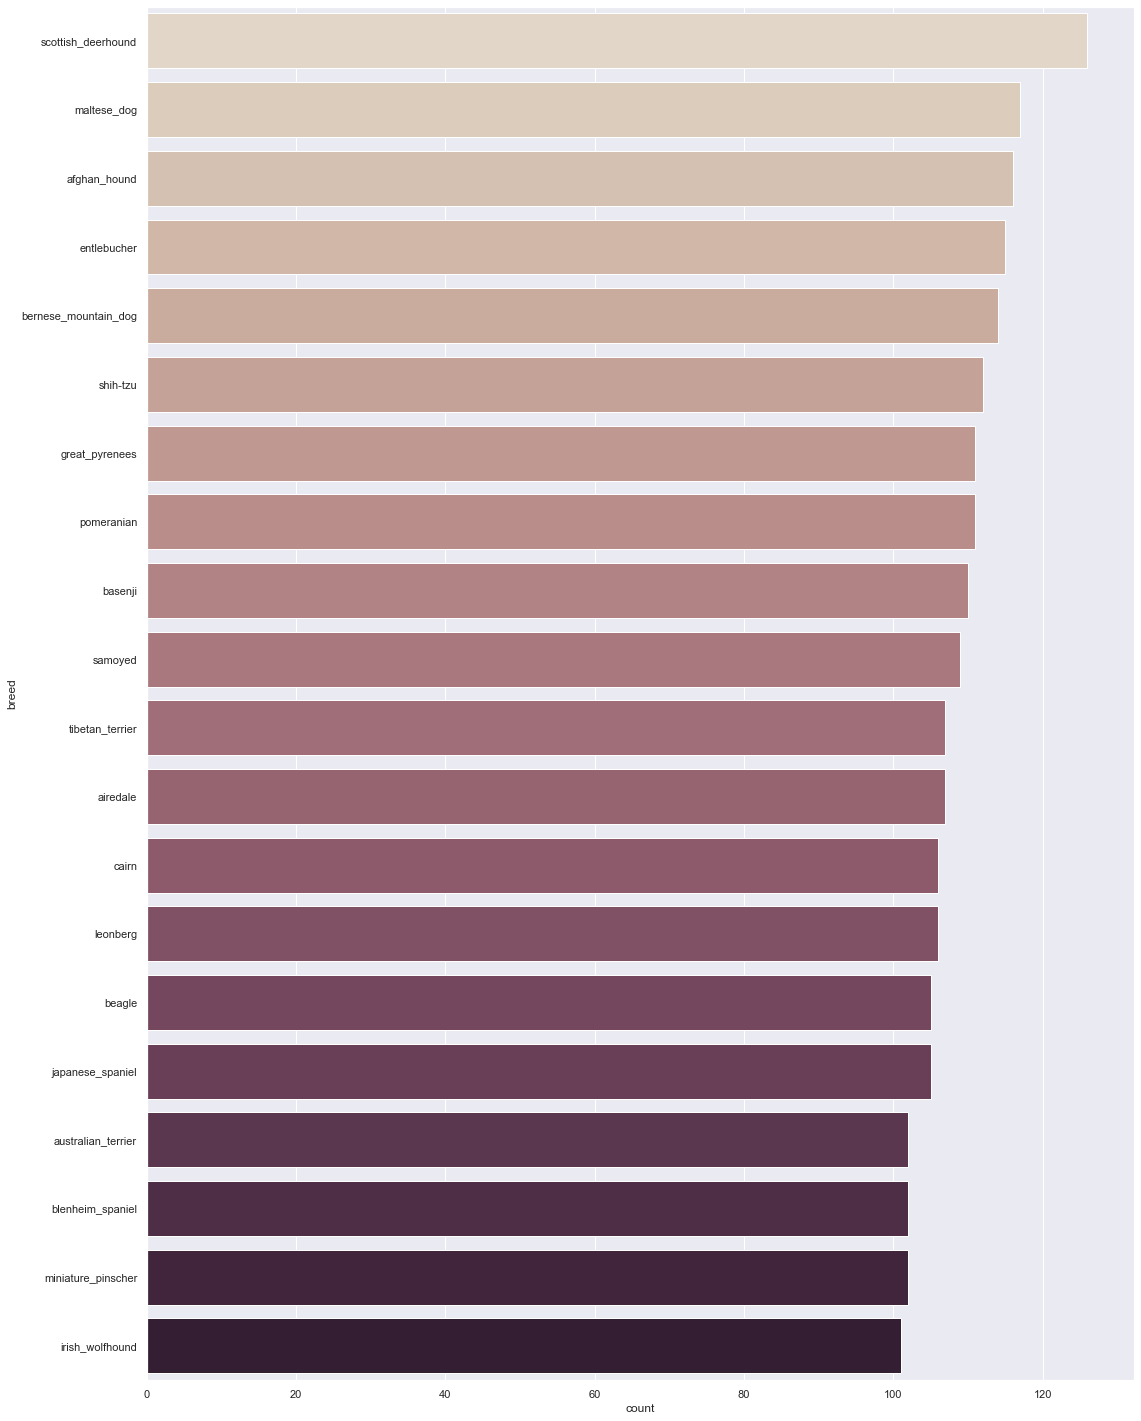

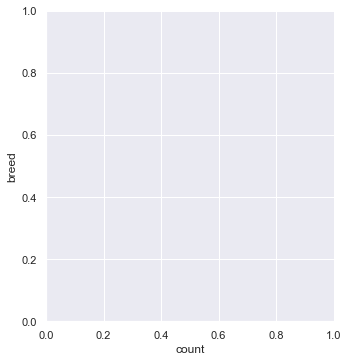

In [9]:
sns.set(style="darkgrid")
sns.set(color_codes=True)
fig, ax = plt.subplots()
fig.set_size_inches(17.7, 25.27)
sns.catplot(y="breed",   kind="count", palette="ch:.25",ax=ax, data=data_labels, order=data_labels.breed.value_counts().iloc[:20].index);


## Prepare Train-Test Datasets
We use a 70-30 split to prepare the two dataset. 

In [10]:
train_data = np.array([img_to_array(
                            load_img(img, 
                                     target_size=(299, 299))
                       ) for img 
                           in data_labels['image_path'].values.tolist()
                      ]).astype('float32')

In [11]:
train_data.shape

(10222, 299, 299, 3)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(train_data, 
                                                    target_labels, 
                                                    test_size=0.3, 
                                                    stratify=np.array(target_labels), 
                                                    random_state=42)

In [13]:
x_train.shape, x_test.shape

((7155, 299, 299, 3), (3067, 299, 299, 3))

Prepare Validation Dataset

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.15, 
                                                    stratify=np.array(y_train), 
                                                    random_state=42)

In [15]:
x_train.shape, x_val.shape

((6081, 299, 299, 3), (1074, 299, 299, 3))

In [16]:
print(y_train.shape)

(6081,)


Prepare target variables for train, test and validation datasets

In [17]:
y_train_ohe = pd.get_dummies(y_train.reset_index(drop=True)).as_matrix()
y_val_ohe = pd.get_dummies(y_val.reset_index(drop=True)).as_matrix()
y_test_ohe = pd.get_dummies(y_test.reset_index(drop=True)).as_matrix()

y_train_ohe.shape, y_test_ohe.shape, y_val_ohe.shape

((6081, 120), (3067, 120), (1074, 120))

## Data Augmentation

Since number of samples per class are not very high, we utilize data augmentation to prepare different variations of different samples available. We do this using the ```ImageDataGenerator utility``` from ```keras```

In [18]:
BATCH_SIZE = 32

In [19]:
# Create train generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=1)

In [20]:
# Create validation generator
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_val, y_val_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=1)

## Prepare Deep Learning Classifier

* Load InceptionV3 pretrained on ImageNet without its top/classification layer
* Add additional custom layers on top of InceptionV3 to prepare custom classifier

In [21]:
# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top = False, input_shape=(299, 299, 3))
print(base_inception.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [22]:
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
total_classes = y_train_ohe.shape[1]
predictions = Dense(total_classes, activation='softmax')(out)

* Stack the two models (InceptionV3 and custom layers) on top of each other 
* Compile the model and view its summary

In [23]:
model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
model.summary()
# Compile 
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

## Model Training
We train the model with a Batch Size of 32 for just 15 Epochs.

The model utilizes the power of transfer learning to achieve a validation accuracy of about __81%__ !

In [24]:
# Train the model
batch_size = BATCH_SIZE
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size
checkpoint = ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=15,
                              callbacks=[checkpoint],
                              verbose=True)

Epoch 1/15
190/190 [==============================] - 434s 2s/step - loss: 4.1397 - accuracy: 0.2349 - val_loss: 2.5393 - val_accuracy: 0.5606

Epoch 00001: val_loss improved from inf to 2.53930, saving model to model-001-0.234915-0.560606.h5
Epoch 2/15
190/190 [==============================] - 415s 2s/step - loss: 2.1919 - accuracy: 0.5578 - val_loss: 1.0769 - val_accuracy: 0.7418

Epoch 00002: val_loss improved from 2.53930 to 1.07691, saving model to model-002-0.557778-0.741843.h5
Epoch 3/15
190/190 [==============================] - 405s 2s/step - loss: 1.3827 - accuracy: 0.6750 - val_loss: 0.7590 - val_accuracy: 0.7697

Epoch 00003: val_loss improved from 1.07691 to 0.75903, saving model to model-003-0.674988-0.769674.h5
Epoch 4/15
190/190 [==============================] - 408s 2s/step - loss: 1.1354 - accuracy: 0.7097 - val_loss: 0.9885 - val_accuracy: 0.7783

Epoch 00004: val_loss did not improve from 0.75903
Epoch 5/15
190/190 [==============================] - 410s 2s/step -

Save the Model

In [25]:
model.save('dog_breed.hdf5')

## Visualize Model Performance

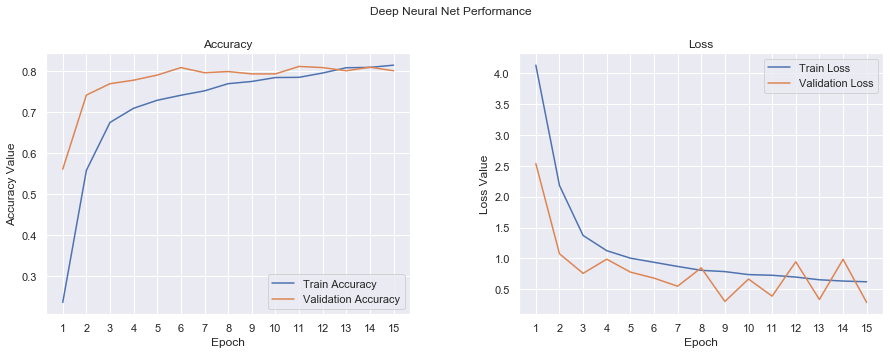

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,16))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Test Model Performance

Step 1 is to prepare the training dataset. Since we scaled training data, test data should also be scaled in a similar manner. 

_Note: Deep Learning models are very sensitive to scaling._

In [27]:
# scaling test features
x_test /= 255.

In [28]:
test_predictions = model.predict(x_test)
test_predictions

array([[3.5157111e-06, 1.3815519e-06, 5.2656919e-06, ..., 1.1404466e-01,
        2.4753285e-07, 1.9335223e-06],
       [2.7610774e-06, 6.4359017e-07, 5.1592895e-05, ..., 1.4078602e-02,
        3.6009369e-04, 5.9761369e-04],
       [3.2316293e-06, 3.1766403e-06, 3.6031699e-06, ..., 2.8421651e-05,
        3.4687189e-06, 1.4009955e-05],
       ...,
       [3.2460795e-07, 1.1049280e-08, 9.3470368e-07, ..., 3.3200394e-07,
        5.7390547e-08, 6.1998371e-08],
       [3.8502817e-06, 1.2118372e-06, 2.3113889e-06, ..., 1.7908113e-05,
        2.0885880e-06, 1.9543268e-06],
       [1.9548725e-05, 1.2771493e-05, 5.9435347e-06, ..., 2.6925998e-06,
        2.4329176e-05, 5.7088979e-05]], dtype=float32)

In [30]:
predictions = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)
predictions.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,3.515711e-06,1.381552e-06,5.265692e-06,1.590145e-07,5.034567e-03,2.207510e-04,5.618899e-08,2.131670e-05,0.000011,2.128808e-05,...,7.468240e-07,1.791712e-06,1.951386e-05,1.183121e-04,5.005409e-04,2.566714e-06,0.000002,1.140447e-01,2.475329e-07,0.000002
1,2.761077e-06,6.435902e-07,5.159290e-05,5.414192e-06,1.430378e-04,4.987193e-04,9.745230e-06,2.501626e-03,0.000039,2.982895e-03,...,7.093685e-05,1.059591e-01,8.781663e-07,3.641072e-04,1.703598e-03,8.460354e-06,0.000042,1.407860e-02,3.600937e-04,0.000598
2,3.231629e-06,3.176640e-06,3.603170e-06,3.619472e-05,3.426308e-05,6.970379e-01,2.614664e-05,9.241105e-05,0.000023,2.628811e-05,...,1.613653e-05,3.500849e-06,3.315593e-06,1.950054e-05,2.681218e-06,1.234048e-05,0.000032,2.842165e-05,3.468719e-06,0.000014
3,5.757403e-07,8.709012e-05,5.632511e-08,6.490525e-07,5.671600e-08,1.684899e-06,1.052022e-06,7.070710e-08,0.000023,1.837244e-06,...,3.276786e-05,5.911181e-08,1.086805e-07,5.299162e-08,1.709475e-07,8.506805e-05,0.000002,7.702427e-07,2.876961e-06,0.000001
4,4.074994e-07,1.437593e-06,5.089396e-07,1.044246e-07,9.262916e-07,7.381098e-07,1.627247e-06,4.591962e-07,0.000001,1.159202e-07,...,2.873900e-07,1.145483e-06,3.379742e-07,2.218214e-07,8.402427e-08,2.044132e-08,0.065084,6.044938e-07,6.594333e-05,0.000001


In [31]:
def get_x_test(img_path, img_height, img_width):
    return np.array([img_to_array(load_img(img_path, target_size=(img_height, img_width)))]).astype('float32')


In [32]:
def predict(x_test, model):
    #x_test = kimage.resize(image, 299, 299) 
    x_test /= 255.0
    test_predictions = model.predict(x_test)
    predictions = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)
    predictions = list(predictions.idxmax(axis=1))
    return predictions
    

In [33]:
def getImagesFilePathsFromFolder(path):
    onlyfiles = [ join(path,f) for f in listdir(path) if ( isfile(join(path, f)) and (".jpg" in f) )]
    return onlyfiles

In [34]:
test_labels = list(y_test)
predictions = list(predictions.idxmax(axis=1))
predictions[:10]

['rhodesian_ridgeback',
 'italian_greyhound',
 'appenzeller',
 'cocker_spaniel',
 'sealyham_terrier',
 'borzoi',
 'chow',
 'bluetick',
 'tibetan_mastiff',
 'malinois']

In [35]:
MODEL_JSON_PATH = "/Volumes/My Passport for Mac/model/dog_beed_model.json"
MODEL_H5_PATH = "/Volumes/My Passport for Mac/model/dog_beed_model.h5"


# serialize model to JSON
model_json = model.to_json()
with open(MODEL_JSON_PATH, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(MODEL_H5_PATH)
print("Saved model to disk")

Saved model to disk


In [36]:
# load json and create model
json_file = open(MODEL_JSON_PATH, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(MODEL_H5_PATH)
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 


Loaded model from disk


/Volumes/My Passport for Mac/data/dog-breeds/test2/00a6892e5c7f92c1f465e213fd904582.jpg
clumber
/Volumes/My Passport for Mac/data/dog-breeds/test2/0a0b97441050bba8e733506de4655ea1.jpg
black-and-tan_coonhound
/Volumes/My Passport for Mac/data/dog-breeds/test2/0a942a4a0b42a50c397ddce75ace89b0.jpg
miniature_schnauzer
/Volumes/My Passport for Mac/data/dog-breeds/test2/0ac820001998537915e7769da3746d27.jpg
labrador_retriever
/Volumes/My Passport for Mac/data/dog-breeds/test2/0ae4367c7f7149a43b0e5b1c07ce7ed9.jpg
clumber


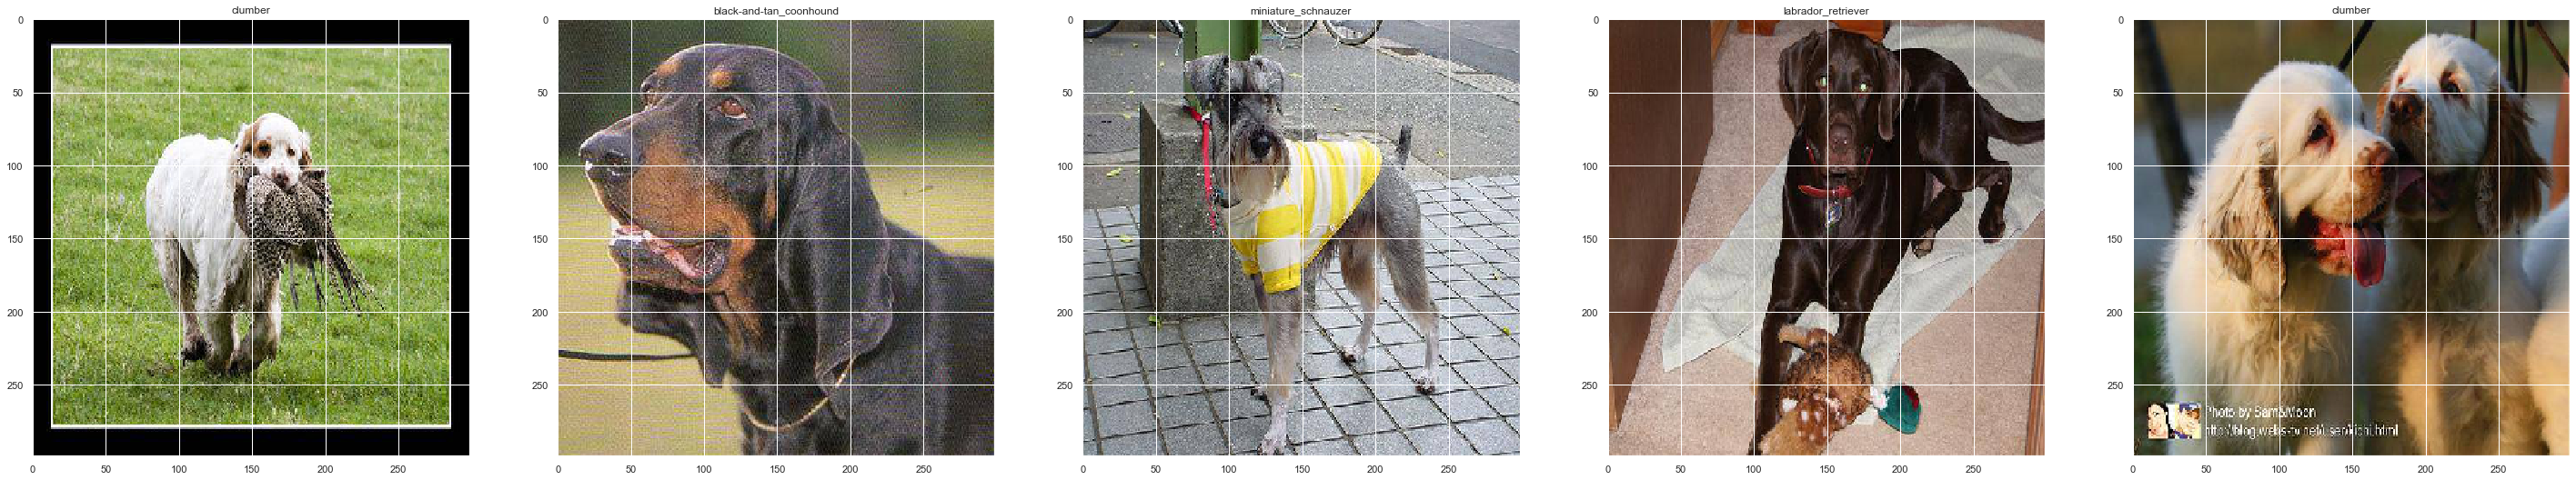

In [37]:
path = "/Volumes/My Passport for Mac/data/dog-breeds/test2"
fileCount = len(getImagesFilePathsFromFolder(path)) 
#print(getImagesFilePathsFromFolder(path))
fig, ax = plt.subplots(1,fileCount, figsize=(50,50))
img_Counter=0;

for img_path in getImagesFilePathsFromFolder(path):
    print(img_path)
    breed = predict(get_x_test(img_path, 299, 299), loaded_model)[0]
    print(breed)
    ax[img_Counter].set_title(breed)
    ax[img_Counter].imshow(load_img(img_path, target_size=(299, 299)))
    img_Counter = img_Counter + 1



## Analyze Test Performance

In [39]:
import model_evaluation_utils as meu

In [40]:
meu.get_metrics(true_labels=test_labels, 
                predicted_labels=predictions)

Accuracy: 0.8663
Precision: 0.8723
Recall: 0.8663
F1 Score: 0.8633


In [41]:
meu.display_classification_report(true_labels=test_labels, 
                                  predicted_labels=predictions, 
                                  classes=list(labels_ohe_names.columns))

                                precision    recall  f1-score   support

                 affenpinscher       0.96      0.92      0.94        24
                  afghan_hound       1.00      0.97      0.99        35
           african_hunting_dog       1.00      0.92      0.96        26
                      airedale       0.84      1.00      0.91        32
american_staffordshire_terrier       0.79      0.50      0.61        22
                   appenzeller       0.66      0.83      0.73        23
            australian_terrier       0.89      0.77      0.83        31
                       basenji       1.00      0.88      0.94        33
                        basset       0.89      0.96      0.92        25
                        beagle       0.86      0.97      0.91        31
            bedlington_terrier       0.93      1.00      0.96        27
          bernese_mountain_dog       0.87      1.00      0.93        34
       black-and-tan_coonhound       0.83      0.87      0.85  

In [42]:
meu.display_confusion_matrix(true_labels=test_labels, 
                                    predicted_labels=predictions, 
                                    classes=list(labels_ohe_names.columns))

                                          Predicted:               \
                                       affenpinscher afghan_hound   
Actual: affenpinscher                             22            0   
        afghan_hound                               0           34   
        african_hunting_dog                        0            0   
        airedale                                   0            0   
        american_staffordshire_terrier             0            0   
...                                              ...          ...   
        welsh_springer_spaniel                     0            0   
        west_highland_white_terrier                0            0   
        whippet                                    0            0   
        wire-haired_fox_terrier                    0            0   
        yorkshire_terrier                          0            0   

                                                                     \
                               

The model achieves a test accuracy of approximately __86%__

## Visualize Model Performance
Visualize model performance with actual images, labels and prediction confidence

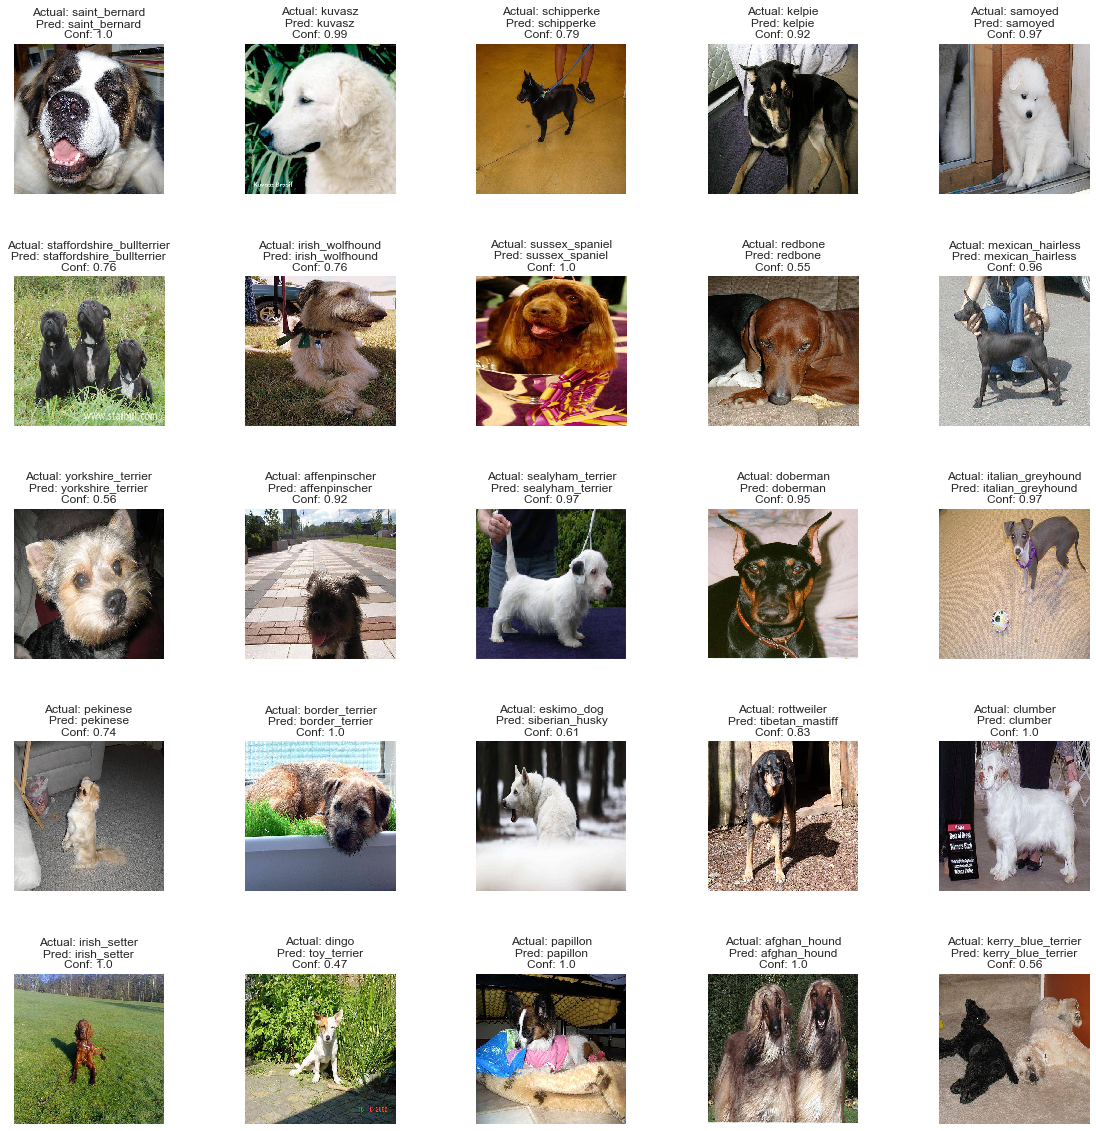

In [43]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)
batch_size = 25
dataset = x_test

label_dict = dict(enumerate(labels_ohe_names.columns.values))
model_input_shape = (1,)+model.get_input_shape_at(0)[1:]
random_batch_indx = np.random.permutation(np.arange(0,len(dataset)))[:batch_size]

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual_label = np.array(y_test)[random_batch_indx[img_idx]]
        prediction = model.predict(dataset[random_batch_indx[img_idx]].reshape(model_input_shape))[0]
        label_idx = np.argmax(prediction)
        predicted_label = label_dict.get(label_idx)
        conf = round(prediction[label_idx], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+actual_label+'\nPred: '+predicted_label + '\nConf: ' +str(conf))
        ax[i][j].imshow(dataset[random_batch_indx[img_idx]])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)    